In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from math import sin, cos, sqrt, atan2, radians
import random
from tqdm import tqdm
import glob
import sys
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
from utils.gsvload import GSVSummary
import h3
import geopandas as gpd
import shapely
from shapely.geometry import Polygon

# Check Vitality Changes across the year groups

In [12]:

ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"
EXFOLDER = os.path.join(CURATED_FOLDER, "c_pano_crossectional")
EXFOLDER_LONG = os.path.join(CURATED_FOLDER, "c_pano_longitudinal")
EXFOLDER_SEG_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal_all")
year_group = ["2015-2018", "2020-2023"]
longfiles = glob.glob(f"{EXFOLDER_LONG}/*.parquet")
segfiles = glob.glob(f"{EXFOLDER_SEG_LONG}/*.parquet")

In [95]:
# check original data, why only 1-2 person observed
def get_seg_types():
    building = [0, 1, 25, 48]
    greenery = [4, 9, 17, 66, 72]
    street_furniture = [19, 15, 31, 69, 82, 136, 138]
    sidewalk = [11]
    car = [20, 80, 83, 102]
    person = [12]
    bike = [127, 116]
    sky = [2]
    sel = building + greenery + street_furniture + sidewalk + car + person + bike +sky
    other = [x for x in range(150) if not x in sel]

    obj_dicts = {
        # "building":building,
        # "greenery":greenery,
        "street_furniture":street_furniture,
        # "sidewalk": sidewalk,
        "car":car,
        "person":person,
        "bike":bike,
        # "sky":sky,
        "other":other,
    }
    def get_cat(label):
        for obj, v in obj_dicts.items():
            if label in v:
                return obj
    obj_dict_rev = {}
    for x in range(150):
        obj_dict_rev[x] = get_cat(x)
    ops = {}
    for label in list(obj_dicts.keys())[:-1]:
        ops[label] = "mean"
    return ops, obj_dict_rev

def get_result(cityabbr, curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob.glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

def clean_pano(panoptic_df, ring):
    _, obj_dict_rev = get_seg_types()
    panoptic_df = panoptic_df[panoptic_df["img"].notnull()].reset_index(drop = True)
    panoptic_df['cat'] = panoptic_df["category_id"].apply(lambda x: obj_dict_rev[x])
    
    panoptic_df = panoptic_df[~panoptic_df['cat'].isin(['other', 'greenery'])].reset_index(drop = True)
    panoptic_df_summary = panoptic_df[panoptic_df['isthing']==True].groupby(["img","cat"])['id'].nunique().reset_index()
    panoptic_df_summary = panoptic_df_summary[panoptic_df_summary["cat"]!="other"].reset_index(drop = True)
    panoptic_df_summary['panoid'] = panoptic_df_summary['img'].apply(lambda x: x[:22])
    panoptic_df_summary_pano = panoptic_df_summary.merge(ring, on = ['panoid'])
    if panoptic_df_summary_pano.shape[0]<panoptic_df_summary.shape[0]:
        print("data missing after data join.")
    else:
        print("data consistent")
    col_cols = ["cat"]
    index_cols = ["img", "year", "h3_6", "h3_9", "h3_12"]
    panoptic_df_summary_pano = panoptic_df_summary_pano.drop_duplicates(index_cols+col_cols)
    print("Segmentation shape: ", panoptic_df_summary_pano.shape[0])
    panoptic_df_pivot = panoptic_df_summary_pano.pivot(
        columns = ["cat"],
        index = ["img", "year", "h3_6", "h3_9", "h3_12"],
        values = "id"
    ).reset_index().fillna(0)
    return panoptic_df_pivot

In [100]:
city = "Hong Kong"
res = 9
variable = "person"
city_abbr = city.lower().replace(" ", "")
panoptic_df = get_result(city_abbr, CURATED_FOLDER)

In [ ]:
panoptic_df[panoptic_df['category_id']==12]

In [105]:
panoptic_df[panoptic_df['category_id']==12].groupby('img')['id'].nunique().sort_values()

img
--5QN8zSU9hRwrDO93i71g_270    1
ei8Jdm4pedUEbAPOtBLETw_270    1
eiS3vnAtkCgGaxyudYYJHg_270    1
eiX7IOzhAQYx5RIm7AcK5A_270    1
eiX7IOzhAQYx5RIm7AcK5A_90     1
                             ..
uy8xzQX8Q8uf9y_oiVi3Zw_90     2
IdjQszUYp3YwjP9KpVELMQ_180    2
lZFpRSTdbhHh6qabExrzhQ_0      2
Fr7tF-chscTLQGuJaE8CVw_180    3
YHYjDGZlCHUY0N7yv-Ijjw_90     3
Name: id, Length: 58494, dtype: int64

In [91]:
city = "Singapore"
res = 9
variable = "person"
city_abbr = city.lower().replace(" ", "")
selfile = [x for x in longfiles if city_abbr in x][0]
segfile = [x for x in segfiles if city_abbr in x][0]

testdf = pd.read_parquet(os.path.join(EXFOLDER, selfile))
testdf = testdf[testdf["res"]==res].reset_index(drop = True)
segdf = pd.read_parquet(os.path.join(EXFOLDER_SEG_LONG, segfile))
segdf = segdf[segdf["res"]==res].reset_index(drop = True)

testdf.head()

cat,hex_id,year_group,street_furniture,car,person,bike,res
0,896520c0e03ffff,2015-2018,0.180000,1.080000,0.000000,0.080000,9
1,896520c0e03ffff,2020-2023,0.200000,1.186667,0.093333,0.013333,9
2,896520c0e0bffff,2015-2018,0.050000,0.950000,0.150000,0.050000,9
3,896520c0e0bffff,2020-2023,0.047619,0.976190,0.047619,0.000000,9
4,896520c0e0fffff,2015-2018,0.062500,0.875000,0.250000,0.125000,9


In [92]:
# make sure only compare the locations with (at least {threshold}) images available in both year_group 
img_count_threshold = 2
seg_df_valid = segdf[segdf['img_count']>=img_count_threshold].groupby("hex_id").filter(lambda x: len(x) == 2)
hex_valid = seg_df_valid[["hex_id","year_group","img_count","res"]].drop_duplicates()
print(segdf.shape[0], seg_df_valid.shape[0])

7398 7026


<Axes: >

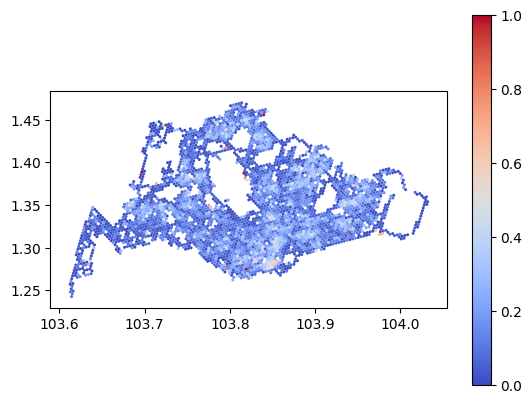

In [93]:
# construct h3 geometry and plot the person

pano_valid_df = hex_valid.merge(testdf, on = ["hex_id",'year_group',"res"], how = "left").fillna(0)
pano_valid_df["geometry"] = pano_valid_df["hex_id"]\
    .apply(lambda x: shapely.geometry.Polygon(h3.h3_to_geo_boundary(x, geo_json = True)))
gdf = gpd.GeoDataFrame(pano_valid_df, geometry = "geometry", crs = "EPSG:4326")
gdf[gdf['year_group']=='2020-2023'].plot(column = variable, legend = True, cmap = 'coolwarm')


<Axes: >

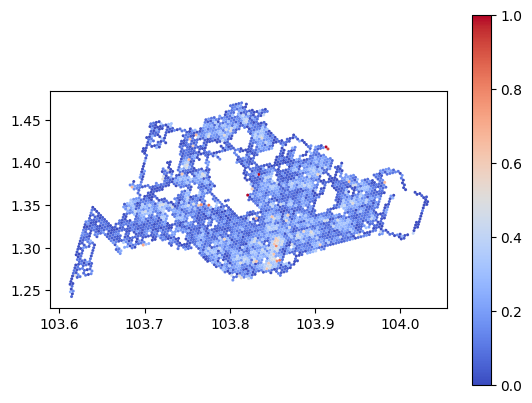

In [94]:
gdf[gdf['year_group']=='2015-2018'].plot(column = variable, legend = True, cmap = 'coolwarm')

In [86]:
# pivot the table and get delta between 2015-2018 and 2020-2023
# variable = "car"
pivot_df = gdf.pivot(index = "hex_id", columns = "year_group", values = variable).reset_index()
pivot_df[f'{variable}_delta'] = pivot_df['2020-2023'] - pivot_df['2015-2018']

<Axes: >

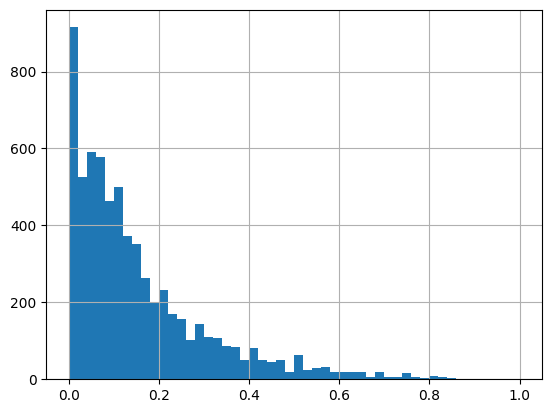

In [87]:
pivot_df['2020-2023'].hist(bins = 50)

<Axes: >

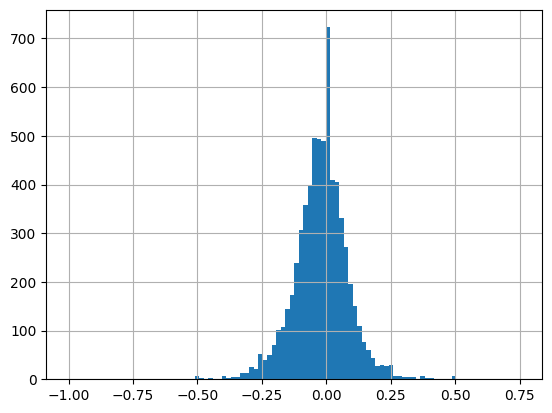

In [88]:
pivot_df[f'{variable}_delta'].hist(bins = 100)

In [89]:
pivot_gdf = gdf[['hex_id','geometry']].drop_duplicates('hex_id')\
    .merge(pivot_df[["hex_id",f'{variable}_delta']], on = "hex_id", how = "left")
pivot_gdf

,hex_id,geometry,person_delta
0,892a100002bffff,"POLYGON ((-73.78386 40.85219, -73.78597 40.851...",0.000000
1,892a100002fffff,"POLYGON ((-73.78162 40.84960, -73.78373 40.848...",0.125000
2,892a1000047ffff,"POLYGON ((-73.79056 40.85996, -73.79267 40.859...",-0.250000
3,892a1000063ffff,"POLYGON ((-73.79038 40.85467, -73.79249 40.853...",0.041721
4,892a1000067ffff,"POLYGON ((-73.78814 40.85208, -73.79025 40.851...",-0.108519
...,...,...,...
6559,892a10776c3ffff,"POLYGON ((-74.01706 40.67684, -74.01916 40.675...",0.042626
6560,892a10776c7ffff,"POLYGON ((-74.01482 40.67426, -74.01692 40.673...",0.115385
6561,892a10776d3ffff,"POLYGON ((-74.01503 40.67954, -74.01713 40.678...",0.209615
6562,892a10776d7ffff,"POLYGON ((-74.01279 40.67696, -74.01489 40.676...",-0.032051


<Axes: >

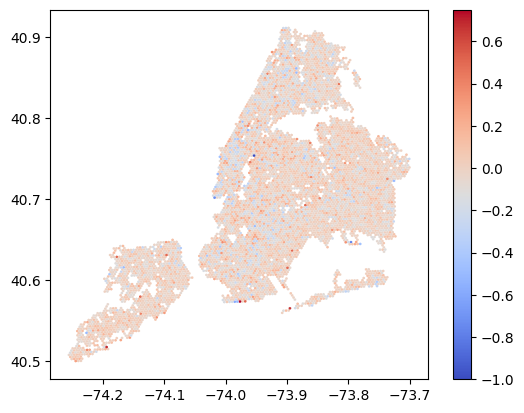

In [90]:
pivot_gdf.plot(column = f'{variable}_delta', legend = True, cmap = 'coolwarm')